# End-to-end SSL stepcounter training with OxWalk, modified with granular postures

This notebook trains the stepcounter that was used in:

Small SR, Chan S, Walmsley R, et al. (2023)
[Development and Validation of a Machine Learning Wrist-worn Step Detection Algorithm with Deployment in the UK Biobank](https://www.medrxiv.org/content/10.1101/2023.02.20.23285750v1).
medRxiv. DOI: 10.1101/2023.02.20.

This notebook has been modified to run on Dr. Keadle's Cal Poly ACT24 data.

Original notebook can be found [here](https://github.com/OxWearables/stepcount/blob/main/train-ssl.ipynb).

## Imports

In [16]:
import re
import glob
import os
import numpy as np
import pandas as pd
import pathlib
import torch
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed

Check torch version and to see if GPU acceleration is available.

This notebook was originally run on torch version 2.2.2+cu121, with GPU acceleration.

In [17]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

2.2.2+cu121
True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Data processing

Below are functions to load the data, adapted from the original functions provided by UK Biobank. Requires the following files:
- ACT24_Apr2024 directory, with ACT24_###_#_SSL.csv files created by the DATA 2024 team. ### is the id, # is the observation.

In [45]:
DATA_DIR = 'ACT24_Apr2024'  # location of data (the ACT24_###_#_SSL.csv files should be in this folder)
DATAFILES = os.path.join(DATA_DIR, 'ACT24_*.csv')
OUT_DIR = './data/act24_80hz_3/'  # output location of the processed dataset
WINDOW_SEC = 10  # seconds per epoch
STEP_THRESHOLD = 4  # how many steps per window to consider a step (equal or more). This is not used in this notebook but is kept as a placeholder

DEVICE_HZ = 80  # original sample rate Hz
RESAMPLE_HZ = 30  # Hz
WINDOW_OVERLAP_SEC = 0  # seconds
WINDOW_LEN = int(DEVICE_HZ * WINDOW_SEC)  # device ticks
WINDOW_OVERLAP_LEN = int(DEVICE_HZ * WINDOW_OVERLAP_SEC)  # device ticks
WINDOW_STEP_LEN = WINDOW_LEN - WINDOW_OVERLAP_LEN  # device ticks
WINDOW_TOL = 0.01  # 1%


def resize(x, length, axis=1):
    """Resize the temporal length using linear interpolation.
    X must be of shape (N,M,C) (channels last) or (N,C,M) (channels first),
    where N is the batch size, M is the temporal length, and C is the number
    of channels.
    If X is channels-last, use axis=1 (default).
    If X is channels-first, use axis=2.
    """
    from scipy.interpolate import interp1d

    length_orig = x.shape[axis]
    t_orig = np.linspace(0, 1, length_orig, endpoint=True)
    t_new = np.linspace(0, 1, length, endpoint=True)
    x = interp1d(t_orig, x, kind="linear", axis=axis, assume_sorted=True)(
        t_new
    )
    return x


def is_good_quality(w):
    """ Window quality check """

    if w.isna().any().any():
        return False

    if len(w) != WINDOW_LEN:
        return False

    w_start, w_end = w.index[0], w.index[-1]
    w_duration = w_end - w_start
    target_duration = pd.Timedelta(WINDOW_SEC, 's')
    if np.abs(w_duration - target_duration) > WINDOW_TOL * target_duration:
        return False

    return True


def make(datafile):
    X, Y, T, P = [], [], [], []
    y_step = []
    Y_all = []

    data = pd.read_csv(datafile, parse_dates=['timestamp'], index_col='timestamp')

    p = re.search(r'(ACT24_\d{3}_\d{1})', datafile, flags=re.IGNORECASE).group()

    for i in range(0, len(data), WINDOW_STEP_LEN):
        w = data.iloc[i:i + WINDOW_LEN]
        postures = w['posture'].mode()

        if not is_good_quality(w) or "private/not coded" in list(postures):
            continue

        t = w.index[0].to_datetime64()
        x = w[['x', 'y', 'z']].values
        posture = postures.sample(n=1).iloc[0]
        count = int(w['step'].sum())
        
        if posture in ['lying', 'kneeling/ squatting', 'stretching', 'stand', 'sitting']:
            y = 'nomvmt'
        elif posture in ['descend stairs', 'walk with load']:
            y = 'modwalk'
        else:
            y = posture
            
        y_all = posture

        X.append(x)
        Y.append(y)
        T.append(t)
        P.append(p)
        y_step.append(count)
        Y_all.append(y_all)

    X = np.asarray(X)
    Y = np.asarray(Y)
    T = np.asarray(T)
    P = np.asarray(P)
    y_step = np.asarray(y_step)
    y_all = np.asarray(Y_all)

    if DEVICE_HZ != RESAMPLE_HZ:
        X = resize(X, int(RESAMPLE_HZ * WINDOW_SEC))

    return X, Y, T, P, y_step, y_all

Convert the raw data into 10s windowed data `X` at 30Hz, with step count annotations `Y_step` and group labels `groups`. A categorical array `Y` is also generated. Save to disk for later reuse. **This means that the code in this section only needs to be run once!**

In [46]:
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

with Parallel(n_jobs=4, prefer="threads") as parallel:
    results = parallel(delayed(make)(datafile) for datafile in tqdm(glob.glob(DATAFILES)))

x, y, t, p, y_step, y_all = zip(*results)

X = np.vstack(x)  # data windows
Y = np.hstack(y)  # binary labels walk/notwalk (based on Y_step >= STEP_THRESHOLD)
Y_step = np.hstack(y_step)  # step counts per window
T = np.hstack(t)  # timestamps
groups = np.hstack(p)  # group ids
Y_all = np.hstack(y_all)

np.save(os.path.join(OUT_DIR, 'X'), X)
np.save(os.path.join(OUT_DIR, 'Y'), Y)
np.save(os.path.join(OUT_DIR, 'time'), T)
np.save(os.path.join(OUT_DIR, 'groups'), groups)
np.save(os.path.join(OUT_DIR, 'Y_step'), Y_step)
np.save(os.path.join(OUT_DIR, 'Y_all'), Y_all)

print(f"Saved in {OUT_DIR}")
print("X shape:", X.shape)
print("Y distribution:")
print(pd.Series(Y).value_counts())

100%|██████████| 32/32 [01:40<00:00,  3.14s/it]


Saved in ./data/act24_80hz_3/
X shape: (32640, 300, 3)
Y distribution:
nomvmt                  25168
walk                     3152
stand and move           2908
modwalk                   841
bike                      262
ascend stairs             171
muscle strengthening       95
other sport movement       42
running                     1
Name: count, dtype: int64


## Load data from disk

The oxwearables activity classifier can only use numeric input, so below we create mappings to convert the posture categorical labels to numbers and back.

In [71]:
posture_to_num = {"nomvmt": 0, "walk": 1, "stand and move": 2, "modwalk": 3, "bike": 4, "ascend stairs": 5, "muscle strengthening": 6, "other sport movement": 7, "running": 8}
num_to_posture = {0: "nomvmt", 1: "walk", 2: "stand and move", 3: "modwalk", 4: "bike", 5: "ascend stairs", 6: "muscle strengthening", 7: "other sport movement", 8: "running"}

Load data from disk. This is what was saved in the previous section. Note that the postures have been converted to numbers.

In [72]:
path = './data/act24_80hz_3/'

X = np.load(path + 'X.npy')
Y_step = np.load(path + 'Y_step.npy')
Y = pd.Series(np.load(path + 'Y.npy')).map(posture_to_num).to_numpy()
groups = np.load(path + 'groups.npy')
T = np.load(path + 'time.npy')

In [73]:
pd.Series(Y).value_counts(normalize=True)

0    0.771078
1    0.096569
2    0.089093
3    0.025766
4    0.008027
5    0.005239
6    0.002911
7    0.001287
8    0.000031
Name: proportion, dtype: float64

## Posture classifier NN code

Below is the neural network that classifies posture, modified to classify more postures as they appear in the ACT24 dataset.

The stepcount dependencies can be downloaded here, if there are any errors in loading the package with pip:
- <https://github.com/OxWearables/stepcount/tree/main/src/stepcount>

In [22]:
import torch
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn.model_selection import GroupShuffleSplit
from stepcount import hmm_utils
from stepcount import sslmodel
from torch.utils.data import DataLoader

from sklearn.utils.class_weight import compute_class_weight

class WalkDetectorSSL:
    def __init__(
            self,
            device='cpu',
            batch_size=100,
            weights_path='state_dict.pt',
            repo_tag='v1.0.0',
            hmm_params=None,
            verbose=False,
    ):
        self.device = device
        self.weights_path = weights_path
        self.repo_tag = repo_tag
        self.batch_size = batch_size
        self.state_dict = None

        self.verbose = verbose

        hmm_params = hmm_params or dict()
        self.hmms = hmm_utils.HMMSmoother(**hmm_params)

    def fit(self, X, Y, groups=None):
        sslmodel.verbose = self.verbose

        if self.verbose:
            print('Training SSL')

        # prepare training and validation sets
        folds = GroupShuffleSplit(
            1, test_size=0.2, random_state=41
        ).split(X, Y, groups=groups)
        train_idx, val_idx = next(folds)

        x_train = X[train_idx]
        x_val = X[val_idx]

        y_train = Y[train_idx]
        y_val = Y[val_idx]

        group_train = groups[train_idx]
        group_val = groups[val_idx]

        train_dataset = sslmodel.NormalDataset(x_train, y_train, pid=group_train, name="training", augmentation=True)
        val_dataset = sslmodel.NormalDataset(x_val, y_val, pid=group_val, name="validation")

        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=1,
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=1,
        )

        # balancing to 90% notwalk, 10% walk
        class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y).tolist()

        model = sslmodel.get_sslnet(tag=self.repo_tag, pretrained=True, class_num=len(np.unique(Y)))
        model.to(self.device)

        sslmodel.train(model, train_loader, val_loader, self.device,
                       class_weights, weights_path=self.weights_path)
        model.load_state_dict(torch.load(self.weights_path, self.device))

        if self.verbose:
            print('Training HMM')

        # train HMM with predictions of the validation set
        y_val, y_val_pred, group_val = sslmodel.predict(model, val_loader,
                                                        self.device,
                                                        output_logits=True)
        y_val_pred_sf = softmax(y_val_pred, axis=1)

        self.hmms.fit(y_val_pred_sf, y_val, groups=group_val)

        # move model to cpu to get a device-less state dict (prevents device conflicts when loading on cpu/gpu later)
        model.to('cpu')
        self.state_dict = model.state_dict()

        return self

    def predict(self, X, groups=None):
        sslmodel.verbose = self.verbose

        dataset = sslmodel.NormalDataset(X, name='prediction')
        dataloader = DataLoader(
            dataset,
            batch_size=512,
            shuffle=False,
            num_workers=0,
        )

        model = sslmodel.get_sslnet(tag=self.repo_tag, pretrained=False, class_num=len(np.unique(Y)))
        model.load_state_dict(self.state_dict)
        model.to(self.device)

        _, y_pred, _ = sslmodel.predict(model, dataloader, self.device, output_logits=False)

        y_pred = self.hmms.predict(y_pred, groups=groups)

        return y_pred

## Train posture classifier

The code below will save the model to the disk. **Don't run more than once!**

In [23]:
wd = WalkDetectorSSL(
    device='cuda' if torch.cuda.is_available() else 'cpu',
    batch_size=512,
    verbose=True
)
wd.fit(X, Y, groups)
joblib.dump(wd, 'keadle3.joblib.lzma', compress=('lzma', 3))

Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Validation loss decreased (inf --> 3.577571). Saving model ...
[  0/100] | train_loss: 1.549 | train_acc: 0.694 | val_loss: 3.578 | val_acc: 0.76


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Validation loss decreased (3.577571 --> 3.033376). Saving model ...
[  1/100] | train_loss: 0.493 | train_acc: 0.796 | val_loss: 3.033 | val_acc: 0.78


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Validation loss decreased (3.033376 --> 2.903039). Saving model ...
[  2/100] | train_loss: 0.368 | train_acc: 0.825 | val_loss: 2.903 | val_acc: 0.80


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.309 | train_acc: 0.840 | val_loss: 3.075 | val_acc: 0.81


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


EarlyStopping counter: 2/5
[  4/100] | train_loss: 0.262 | train_acc: 0.855 | val_loss: 3.105 | val_acc: 0.83


100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


EarlyStopping counter: 3/5
[  5/100] | train_loss: 0.215 | train_acc: 0.869 | val_loss: 3.364 | val_acc: 0.80


100%|██████████| 50/50 [00:22<00:00,  2.17it/s]


EarlyStopping counter: 4/5
[  6/100] | train_loss: 0.195 | train_acc: 0.876 | val_loss: 3.329 | val_acc: 0.83


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


EarlyStopping counter: 5/5
[  7/100] | train_loss: 0.176 | train_acc: 0.883 | val_loss: 3.410 | val_acc: 0.83
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


['keadle3.joblib.lzma']

## Predict postures

In [94]:
wd = joblib.load('keadle3.joblib.lzma')

In [95]:
Y_hat = wd.predict(X, groups)

Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 64/64 [00:06<00:00,  9.72it/s]


Observed posture distribution:

In [96]:
obs = pd.Series(Y).map(num_to_posture)
obs.value_counts()

nomvmt                  25168
walk                     3152
stand and move           2908
modwalk                   841
bike                      262
ascend stairs             171
muscle strengthening       95
other sport movement       42
running                     1
Name: count, dtype: int64

Predicted posture distribution:

In [97]:
pred = pd.Series(Y_hat).map(num_to_posture)
pred.value_counts()

nomvmt                  23324
stand and move           5311
walk                     2925
modwalk                   880
ascend stairs             147
muscle strengthening       53
Name: count, dtype: int64

Error (in # of epochs classified) by posture:

In [98]:
results = pd.concat([obs.value_counts(), pred.value_counts()], axis=1).fillna(0).astype(int)
results.columns = ["obs", "pred"]
results["error"] = np.abs(results["obs"] - results["pred"])
results["perror"] = np.round(results["error"] / results["obs"], 4) * 100
results

,obs,pred,error,perror
nomvmt,25168,23324,1844,7.33
walk,3152,2925,227,7.20
stand and move,2908,5311,2403,82.63
modwalk,841,880,39,4.64
bike,262,0,262,100.00
ascend stairs,171,147,24,14.04
muscle strengthening,95,53,42,44.21
other sport movement,42,0,42,100.00
running,1,0,1,100.00


Posture classifier confusion matrix:

In [99]:
Y_cat = np.unique(np.load(path+'Y.npy'))

In [100]:
conf = pd.crosstab(pd.Categorical(obs, categories=Y_cat), pd.Categorical(pred, categories=Y_cat), dropna=False)
conf.index.name = "obs"
conf.columns.name = "pred"
conf

pred,ascend stairs,bike,modwalk,muscle strengthening,nomvmt,other sport movement,running,stand and move,walk
obs,,,,,,,,,
ascend stairs,139,0,11,0,2,0,0,9,10
bike,0,0,0,0,0,0,0,262,0
modwalk,4,0,646,0,26,0,0,66,99
muscle strengthening,0,0,0,40,55,0,0,0,0
nomvmt,0,0,78,13,22526,0,0,2412,139
other sport movement,0,0,0,0,34,0,0,8,0
running,0,0,0,0,1,0,0,0,0
stand and move,1,0,59,0,545,0,0,2161,142
walk,3,0,86,0,135,0,0,393,2535


Posture classifier accuracy:

In [101]:
accuracy = np.diag(conf).sum() / conf.sum().sum()
accuracy

0.8592830882352941

Posture classifier recall by posture:

In [102]:
recall = np.diag(conf) / conf.sum(axis=1)
recall

obs
ascend stairs           0.812865
bike                    0.000000
modwalk                 0.768133
muscle strengthening    0.421053
nomvmt                  0.895025
other sport movement    0.000000
running                 0.000000
stand and move          0.743122
walk                    0.804251
dtype: float64

Posture classifier precision by posture:

In [103]:
precision = np.diag(conf) / conf.sum(axis=0)
precision

pred
ascend stairs           0.945578
bike                         NaN
modwalk                 0.734091
muscle strengthening    0.754717
nomvmt                  0.965786
other sport movement         NaN
running                      NaN
stand and move          0.406891
walk                    0.866667
dtype: float64

Posture classifier F1 score by posture:

In [104]:
f1 = 2 * precision * recall / (precision + recall)
f1

pred
ascend stairs           0.874214
bike                         NaN
modwalk                 0.750726
muscle strengthening    0.540541
nomvmt                  0.929060
other sport movement         NaN
running                      NaN
stand and move          0.525855
walk                    0.834293
dtype: float64

## Tune step counter

Uses peak detection scipy algorithm to count steps. The distance and prominence are tuned to minimize mean absolute error (MAE) in steps. This is a modified version of the `.fit()` method for the StepCount object in the stepcount package.

Again, the stepcount dependencies can be downloaded manually from here in case of difficulties loading the package from pip:
- <https://github.com/OxWearables/stepcount/tree/main/src/stepcount>

In [105]:
from stepcount.models import toV, calc_sample_weight, batch_count_peaks_from_V, get_cv_scores
from sklearn import metrics
from scipy.optimize import minimize

In [116]:
sample_rate = 30
lowpass_hz = 5
pnr = 1.0

Yp = np.zeros_like(Y)
find_peaks_params = {}
for label in range(1, 10):
    W = (Y == label)
    
    whr_walk_pred = (Y_hat == label)
    Xw, Yw = X[whr_walk_pred], Y_step[whr_walk_pred]
    if len(Yw) == 0:
        continue
    Vw = toV(Xw, sample_rate, lowpass_hz)
    
    sample_weight = calc_sample_weight(W, pnr)
    sample_weight_w = sample_weight[whr_walk_pred]
    
    def to_params(x):
        params = {
            "distance": x[0],
            "prominence": x[1],
        }
        return params
    
    def mae(x):
        Ywp = batch_count_peaks_from_V(Vw, sample_rate, to_params(x))
        err = metrics.mean_absolute_error(Yw, Ywp, sample_weight=sample_weight_w)
        return err
    
    res = minimize(
        mae,
        x0=[.5, .5],
        bounds=[
            (.2, 2),  # 0.2s to 2s (4Hz - 0.5Hz)
            (.15, 1),  # 0.15g to 1g
        ],
        method='Nelder-Mead'
    )
    
    find_peaks_params[label] = to_params(res.x)
    
    Yp[whr_walk_pred] = batch_count_peaks_from_V(Vw, sample_rate, find_peaks_params[label])

Distance and prominence for the peak detector for each category:

In [108]:
find_peaks_params

{1: {'distance': 0.3035156250000057, 'prominence': 0.15},
 2: {'distance': 0.6689453125, 'prominence': 0.21953124999999973},
 3: {'distance': 0.27695312500000724, 'prominence': 0.15},
 5: {'distance': 0.3813476562499989, 'prominence': 0.15},
 6: {'distance': 0.36484374999999925, 'prominence': 1.0}}

Predicted step count overall:

In [109]:
Yp.sum()

89850

Observed step count overall:

In [110]:
Y_step.sum()

89248

Error between predicted and observed step counts, by each id/obs:

In [111]:
preds = pd.concat([pd.Series(groups), pd.Series(Y_step), pd.Series(Yp)], axis=1)
results = preds.groupby(0).sum()
results['error'] = results[1] - results[2]
results['abs_per_error'] = results['error'].abs() / results[1]
results

,1,2,error,abs_per_error
0,,,,
ACT24_116_1,4492,2999,1493,0.332369
ACT24_116_2,443,2269,-1826,4.121896
ACT24_117_1,5808,5270,538,0.092631
ACT24_117_2,3065,2948,117,0.038173
ACT24_122_1,319,415,-96,0.300940
ACT24_122_2,10909,11343,-434,0.039784
ACT24_124_1,2676,2556,120,0.044843
ACT24_124_2,1879,2300,-421,0.224055
ACT24_126_2,1446,1513,-67,0.046335


Cumulative step plots for each id/obs:

In [112]:
import matplotlib.pyplot as plt

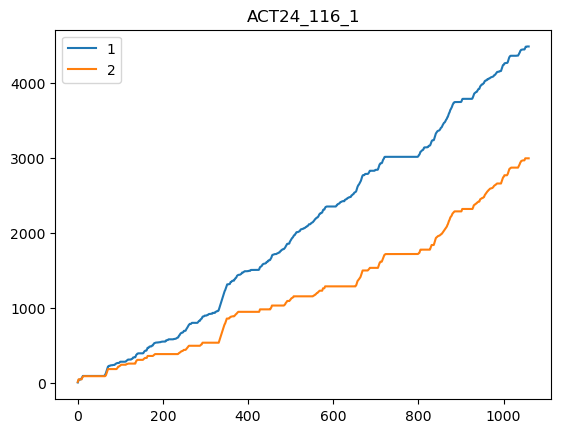

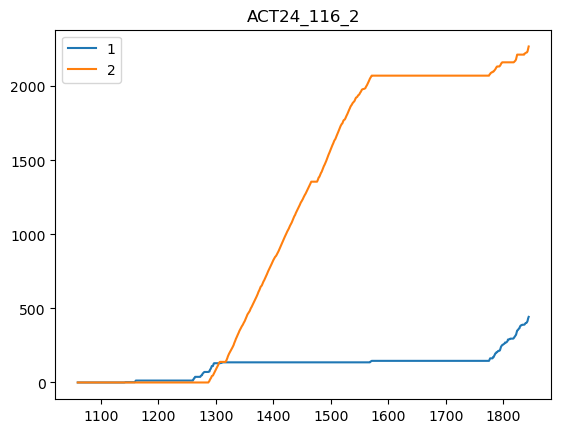

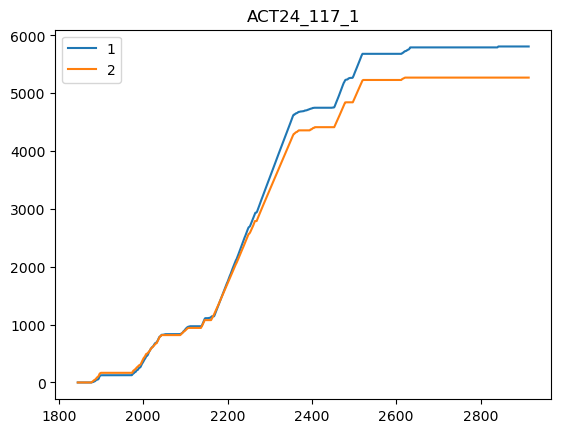

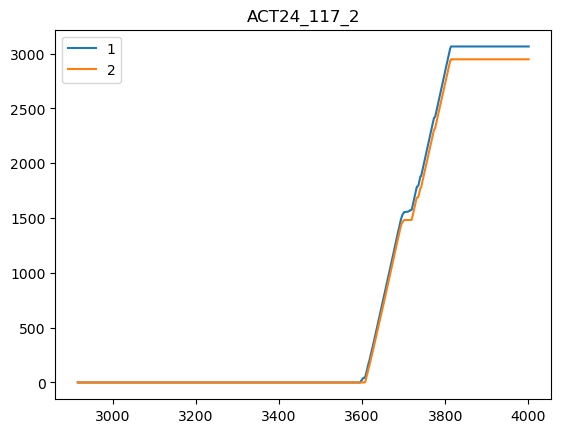

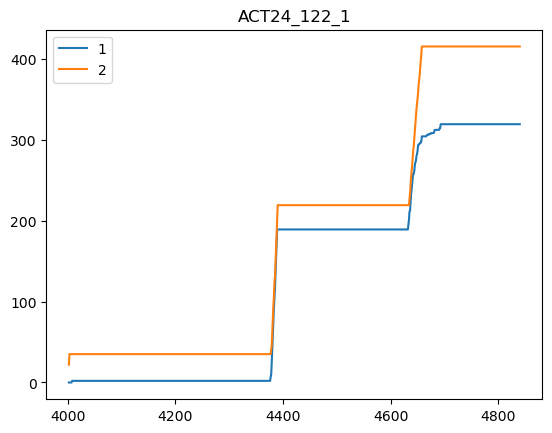

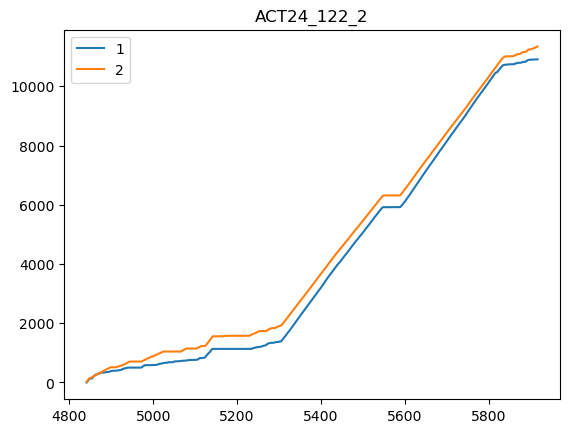

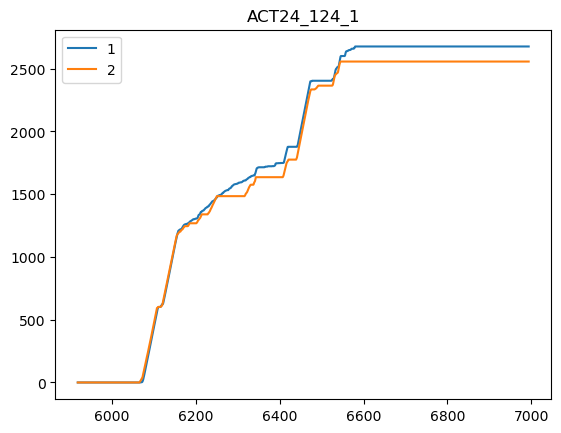

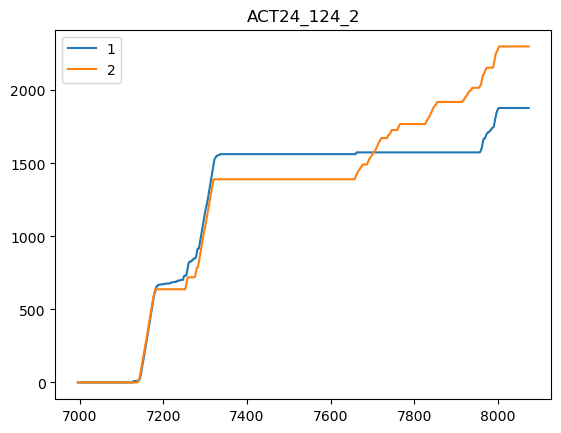

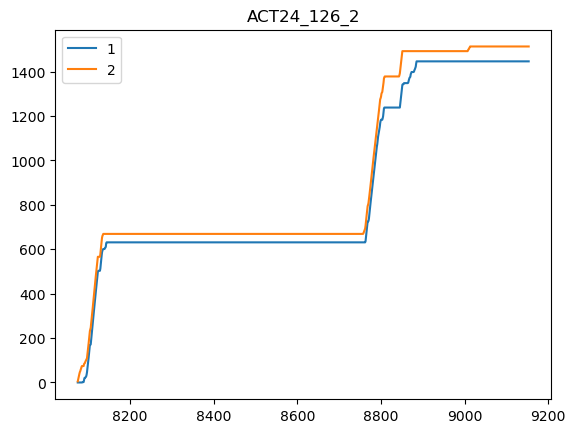

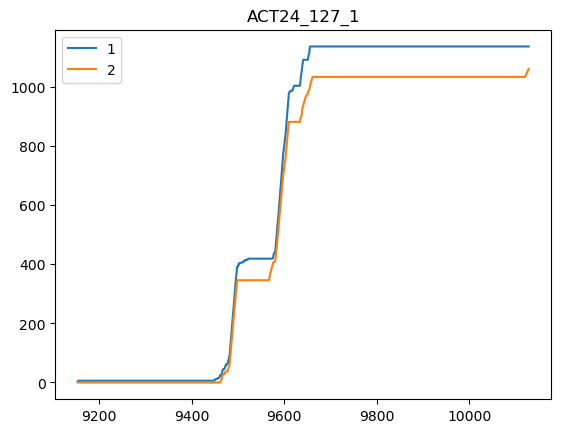

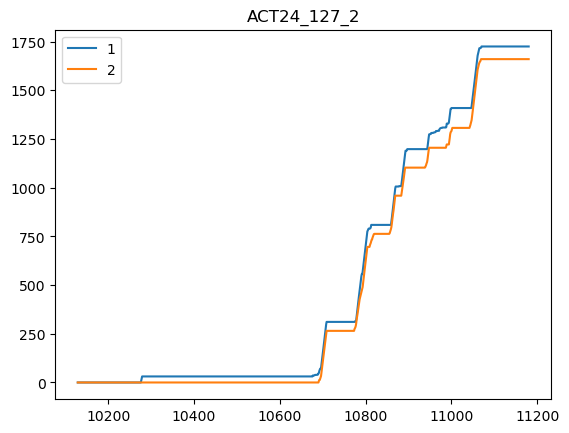

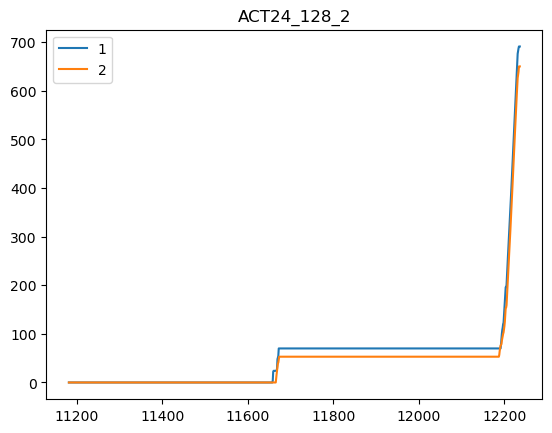

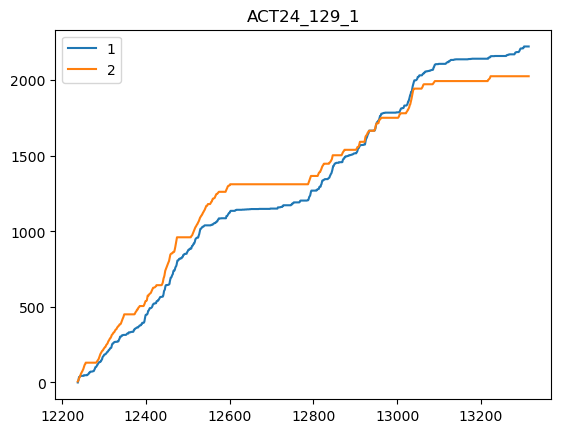

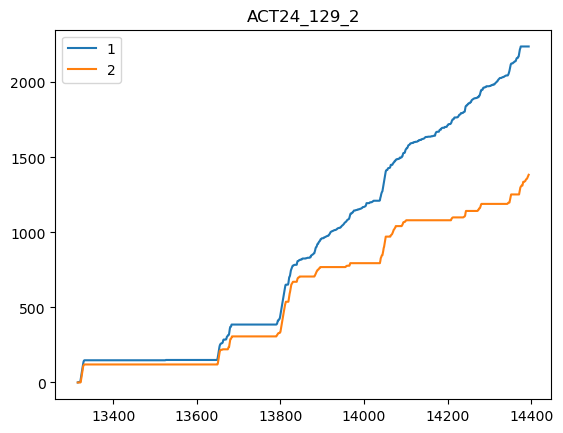

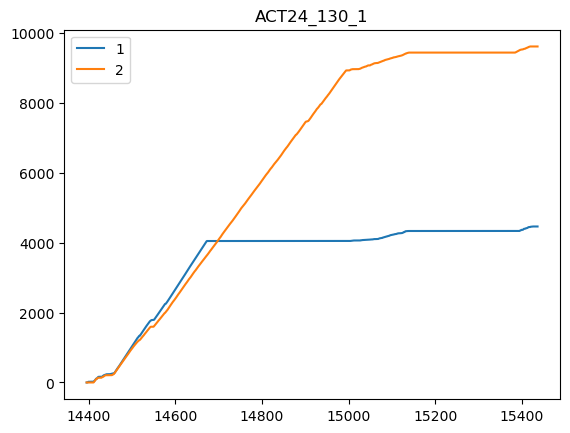

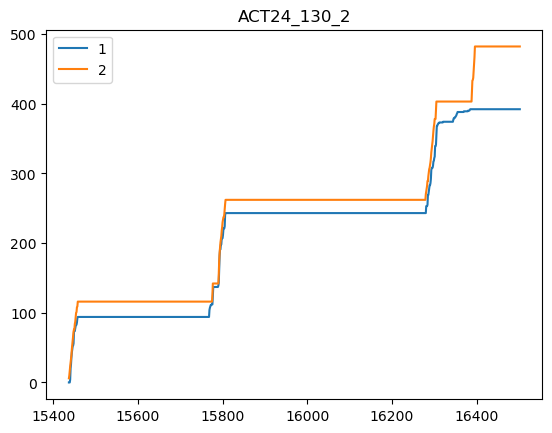

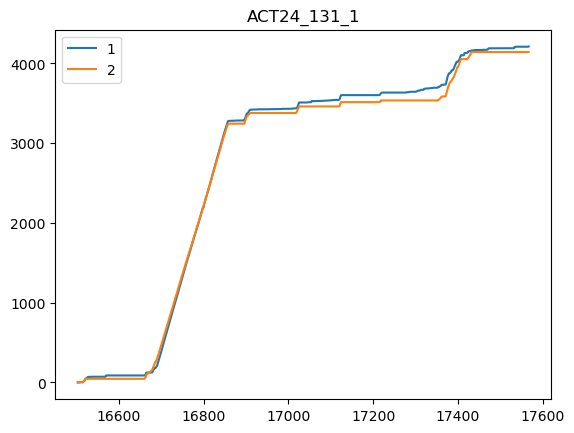

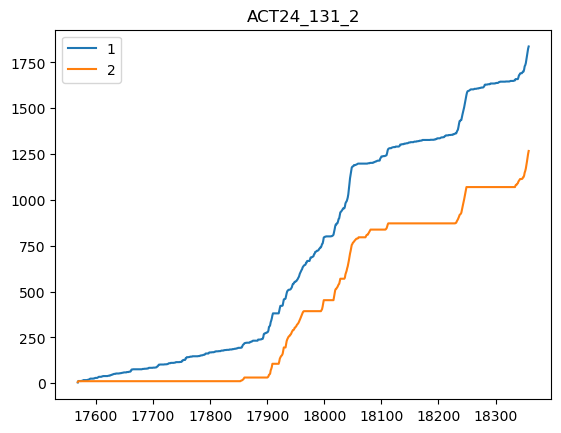

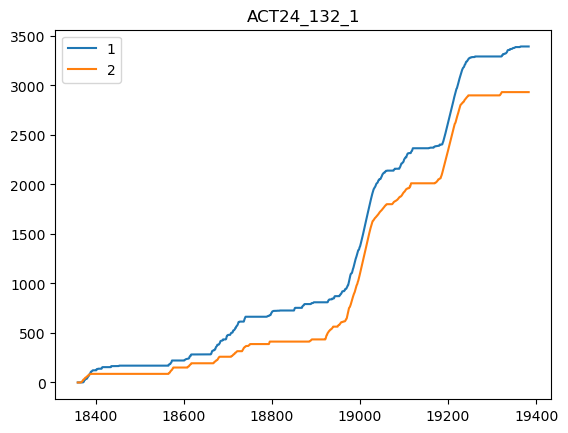

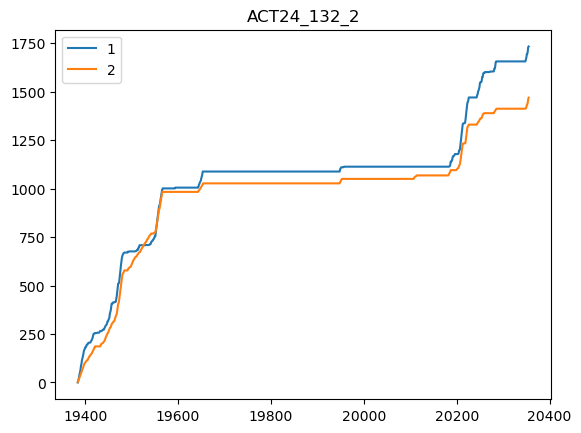

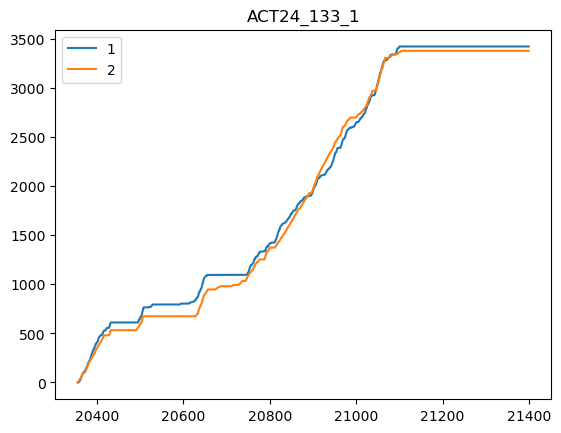

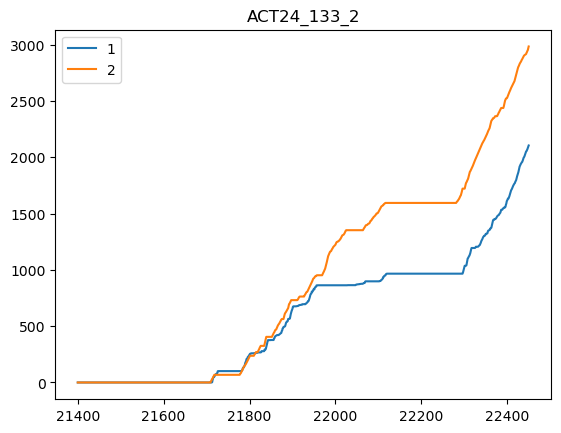

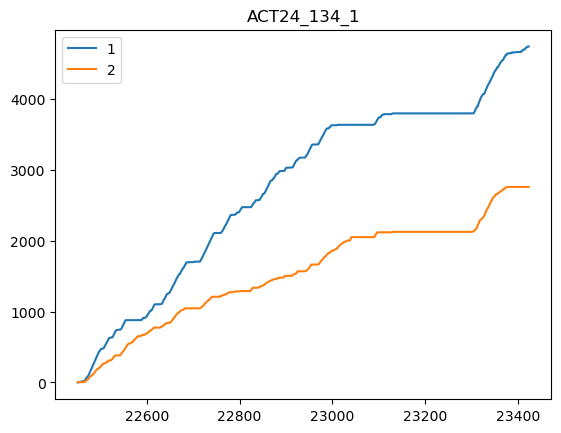

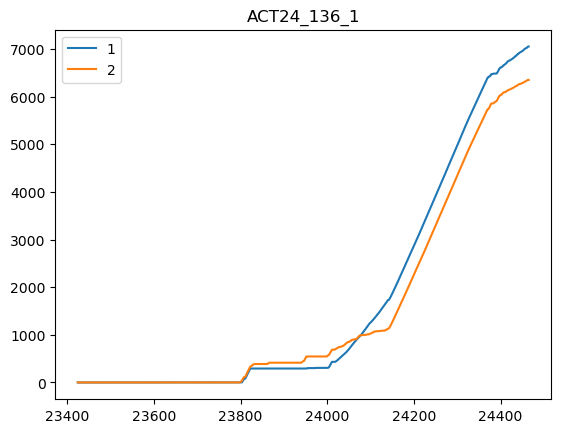

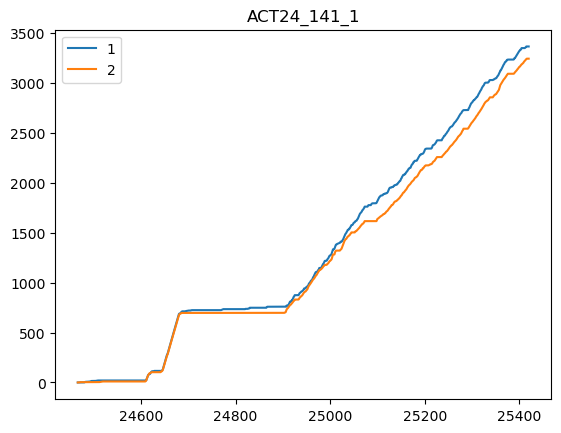

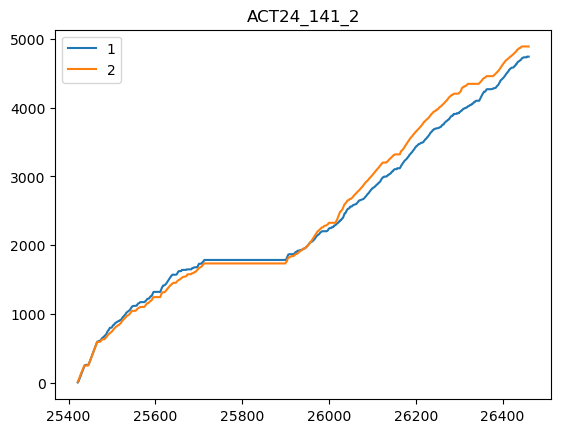

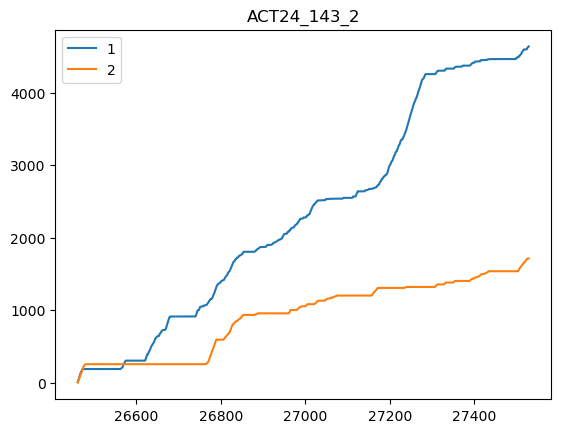

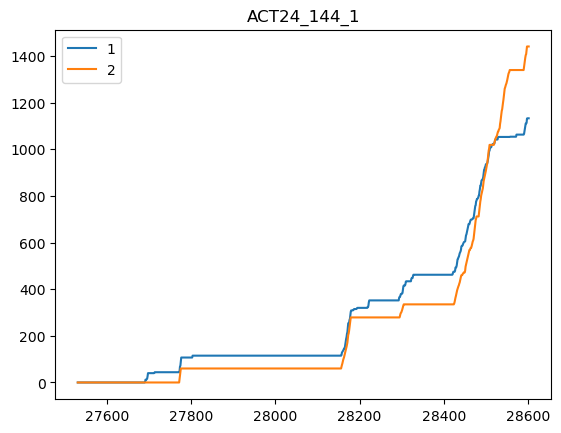

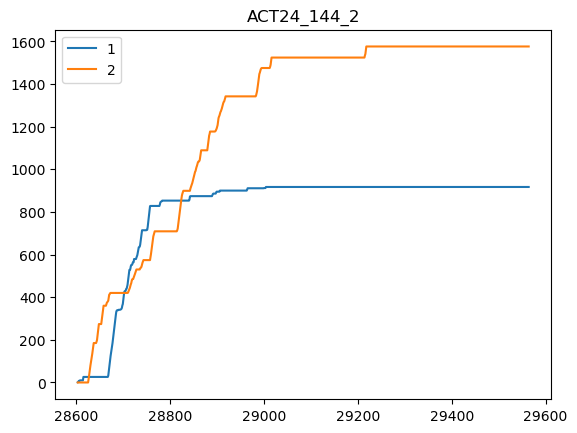

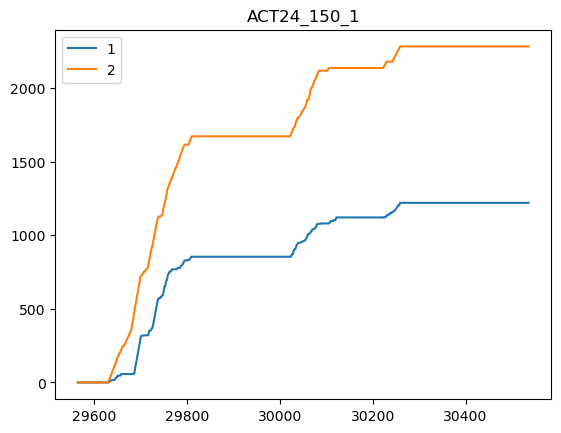

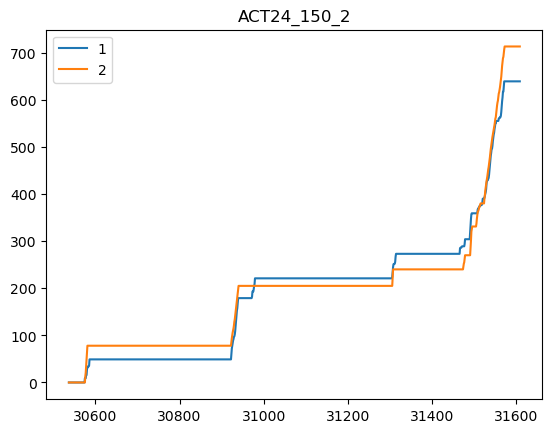

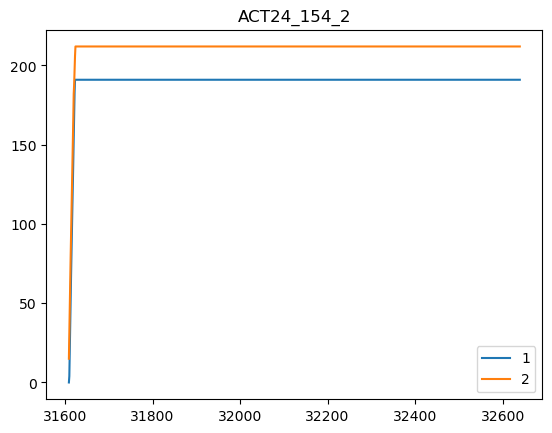

In [113]:
for g in np.unique(groups):
    preds[preds[0] == g][[1,2]].cumsum().plot.line()
    plt.title(g)
    plt.show()

Error between predicted and observed step counts, by posture:

In [114]:
Y_all = np.load(path + "Y_all.npy")
Y_all

array(['stand and move', 'walk', 'walk', ..., 'sitting', 'sitting',
       'sitting'], dtype='<U20')

In [115]:
pred = pd.concat([pd.Series(Y_all),
                  pd.Series(Y_step), pd.Series(Yp)], axis=1)
results = pred.groupby(0).sum()
results['error'] = results[1] - results[2]
results['abs_per_error'] = results['error'].abs() / results[1]
results

,1,2,error,abs_per_error
0,,,,
ascend stairs,1980,1099,881,0.444949
bike,0,1978,-1978,inf
descend stairs,862,941,-79,0.091647
kneeling/ squatting,514,582,-68,0.132296
lying,25,7,18,0.720000
muscle strengthening,33,4,29,0.878788
other sport movement,81,26,55,0.679012
running,0,0,0,NaN
sitting,2756,3321,-565,0.205007


# Output predictions

Output predictions to .csv

In [49]:
pred_k = pd.concat([pd.Series(groups), pd.Series(T), pd.Series(Yp)], axis=1).rename(columns={0: "id_obs", 1: "time", 2: "pred_steps"})
pred_k

,id_obs,time,pred_steps
0,ACT24_116_1,2019-08-20 08:09:05,15
1,ACT24_116_1,2019-08-20 08:09:15,17
2,ACT24_116_1,2019-08-20 08:09:25,17
3,ACT24_116_1,2019-08-20 08:09:35,0
4,ACT24_116_1,2019-08-20 08:09:45,0
...,...,...,...
32635,ACT24_154_2,2020-02-23 15:55:09,0
32636,ACT24_154_2,2020-02-23 15:55:19,0
32637,ACT24_154_2,2020-02-23 15:55:29,0
32638,ACT24_154_2,2020-02-23 15:55:39,0


In [ ]:
pred_k.to_csv("predicted_keadle_goldilocks.csv")

## Test algorithm

Test on oxwalk dataset

In [57]:
path = './data/oxwalk_30hz_w10_o0/'

X_test = np.load(path + 'X.npy')
Y_step_test = np.load(path + 'Y_step.npy')
groups_test = np.load(path + 'groups.npy')
T_test = np.load(path + 'time.npy')

In [58]:
Yp_cat_test = wd.predict(X_test, groups_test)

Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 27/27 [00:03<00:00,  8.53it/s]


In [87]:
Yp_test = np.zeros_like(Yp_cat_test)
for label in range(1, 10):
    W = (Yp_cat_test == label)
    
    whr_walk_pred = (Yp_cat_test == label)
    Xw, Yw = X_test[whr_walk_pred], Y_step_test[whr_walk_pred]
    if len(Yw) == 0:
        continue
    Vw = toV(Xw, sample_rate, lowpass_hz)
    
    Yp_test[whr_walk_pred] = batch_count_peaks_from_V(Vw, sample_rate, find_peaks_params[label])

In [89]:
sum(Yp_test), sum(Y_step_test)

(61933, 62841)

In [90]:
preds = pd.concat([pd.Series(groups_test), pd.Series(Y_step_test), pd.Series(Yp_test)], axis=1)
results = preds.groupby(0).sum()
results['error'] = results[1] - results[2]
results['abs_per_error'] = results['error'].abs() / results[1]
results

,1,2,error,abs_per_error
0,,,,
P01,867,843,24,0.027682
P02,477,651,-174,0.364780
P03,4144,4029,115,0.027751
P04,209,253,-44,0.210526
P05,528,398,130,0.246212
P06,441,528,-87,0.197279
P07,2368,2337,31,0.013091
P08,382,347,35,0.091623
P09,431,425,6,0.013921


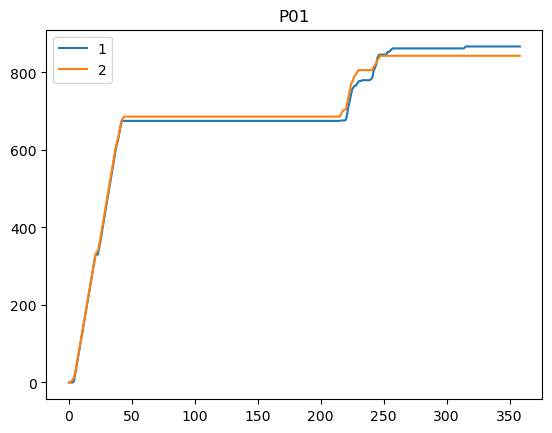

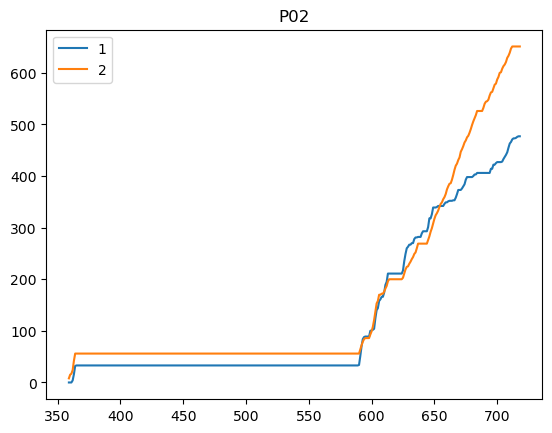

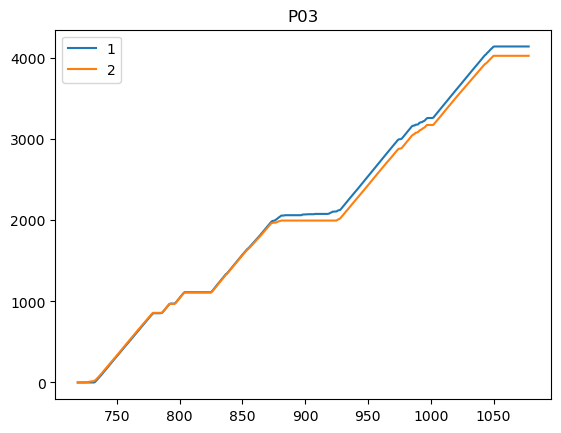

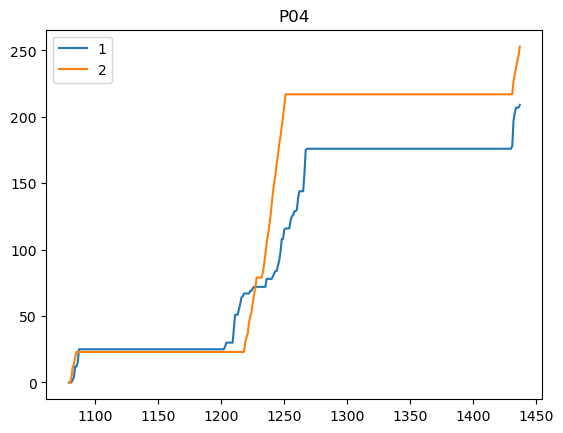

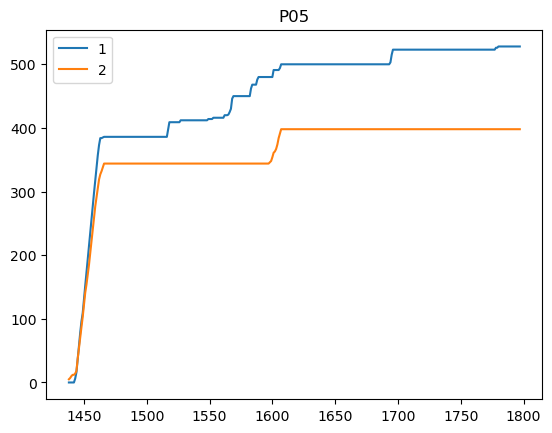

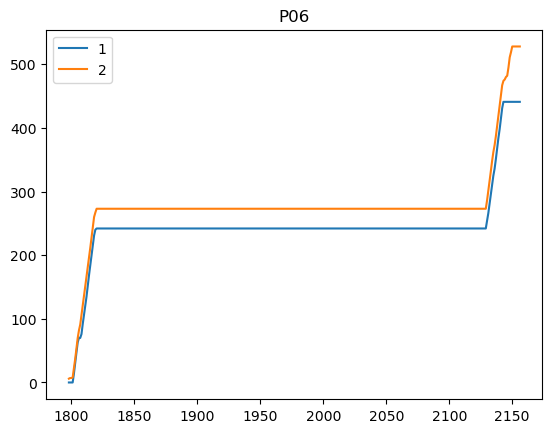

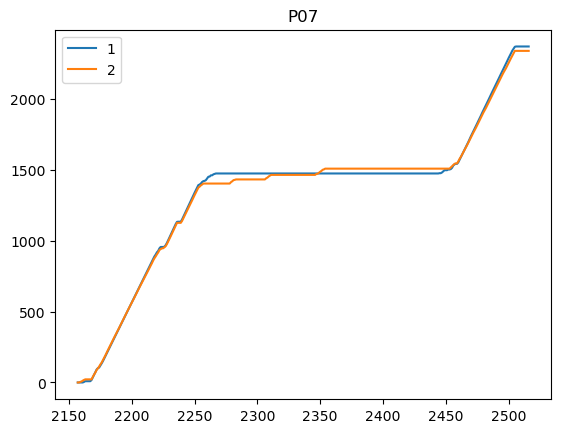

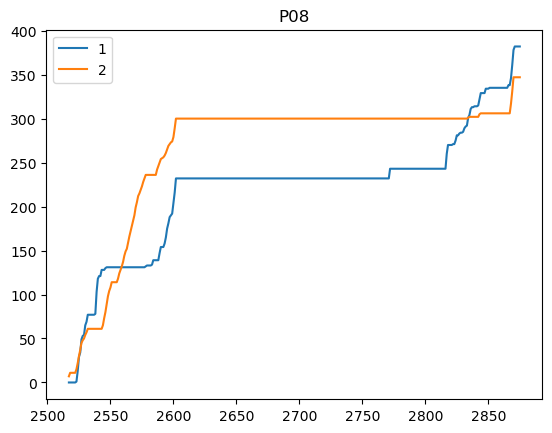

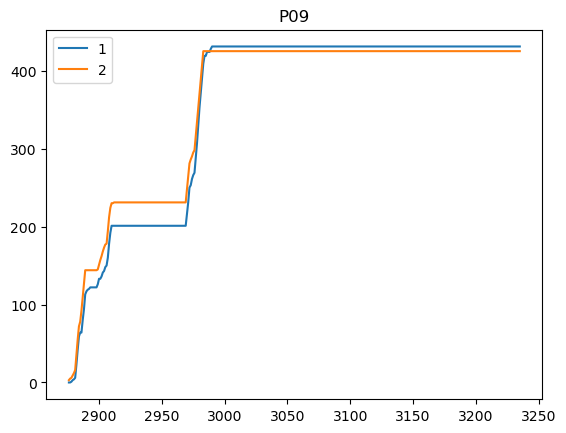

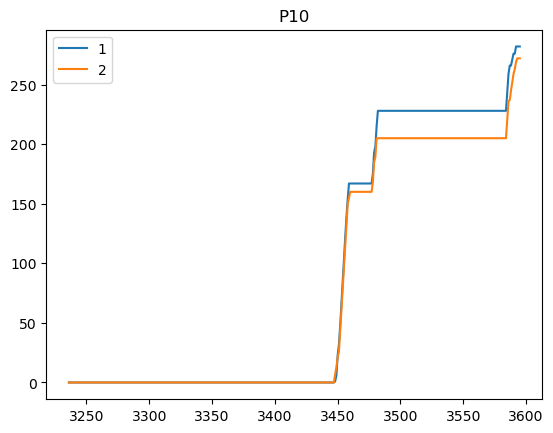

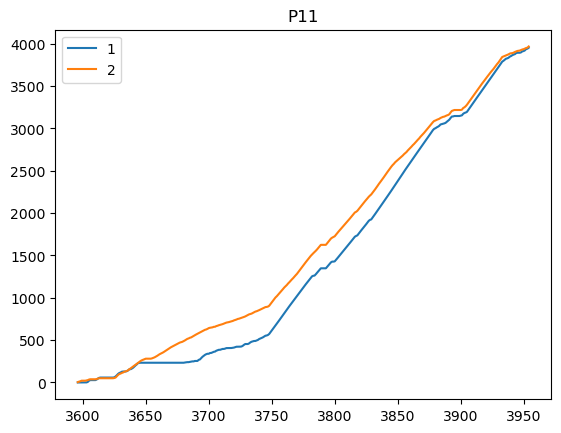

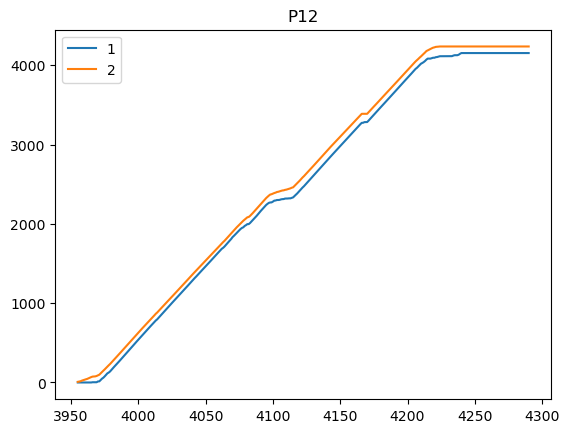

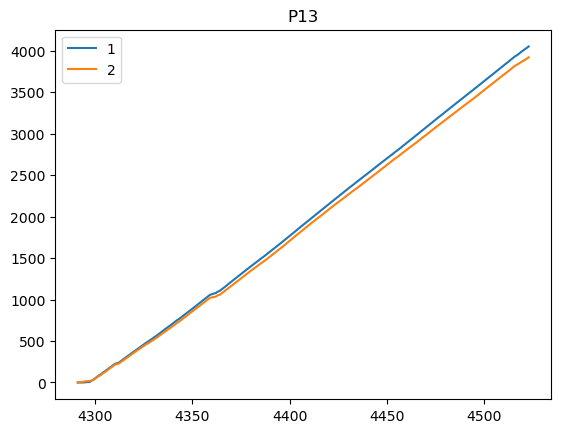

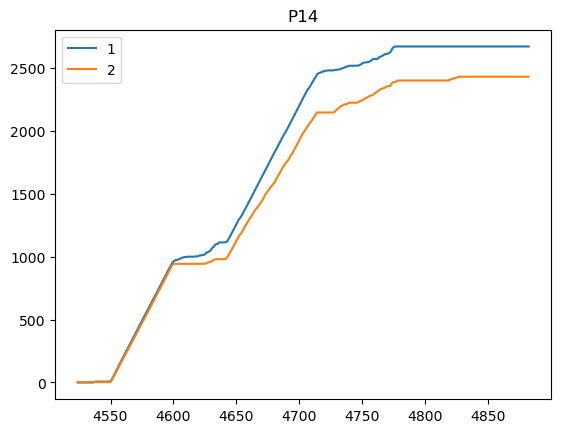

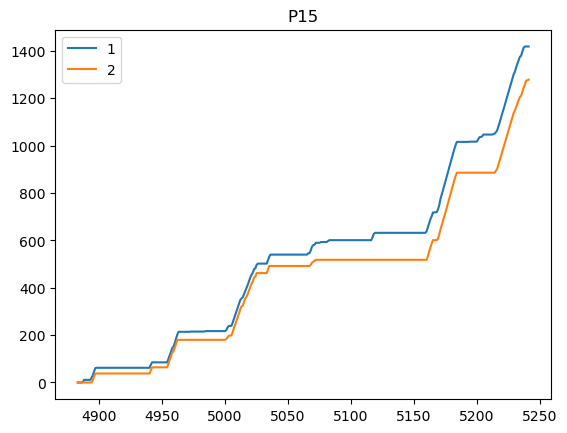

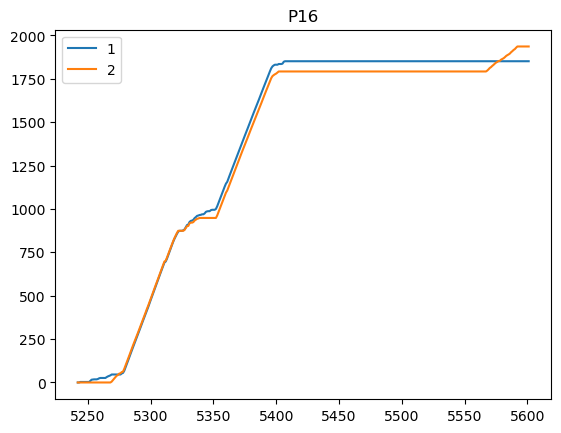

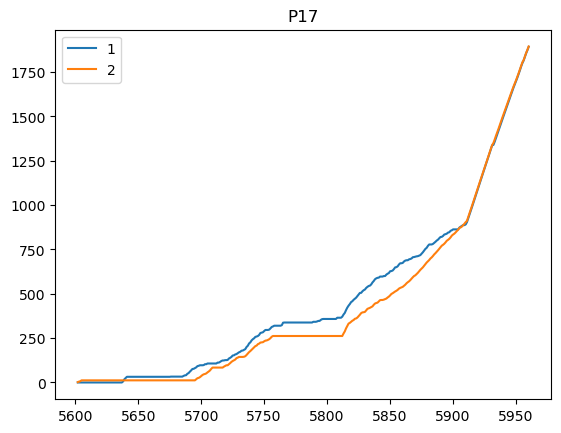

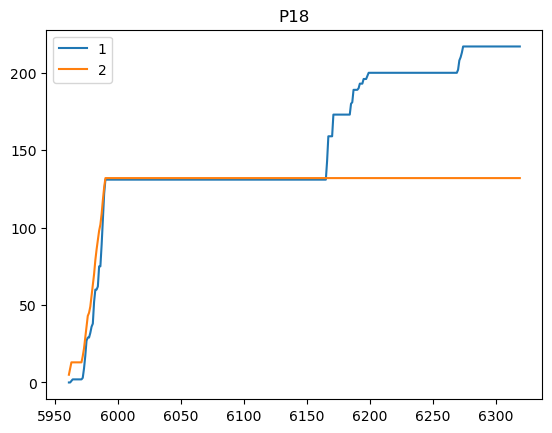

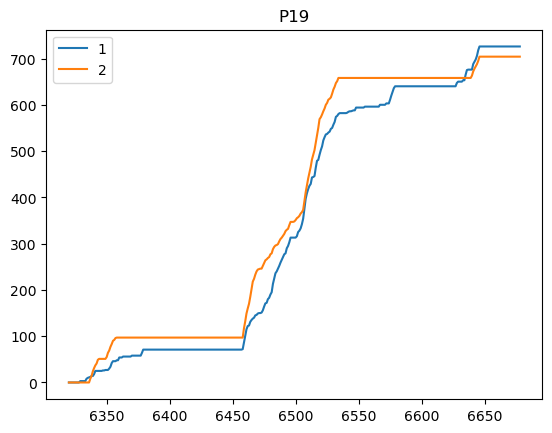

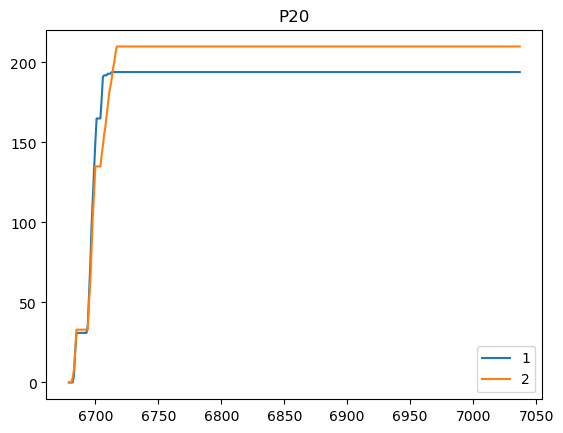

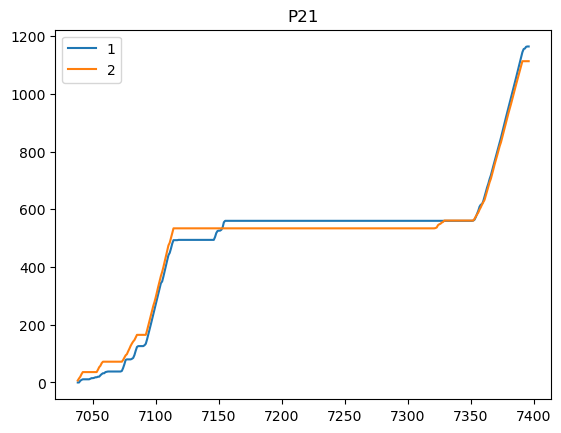

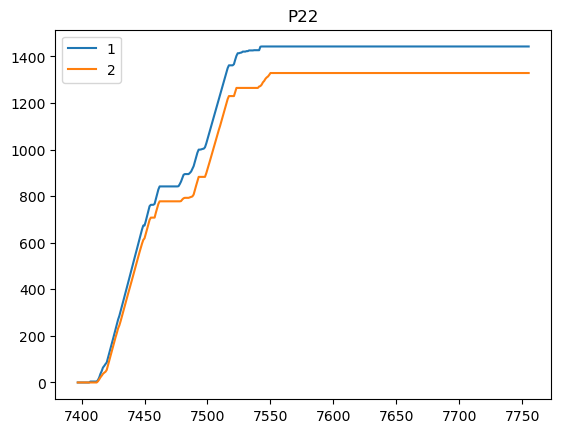

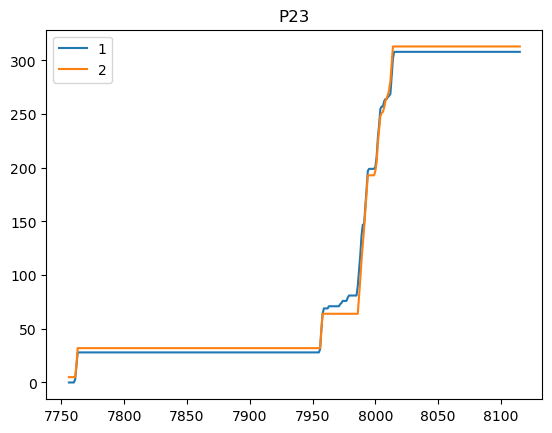

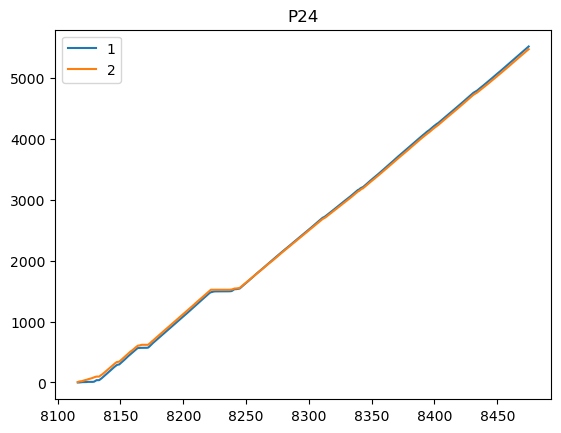

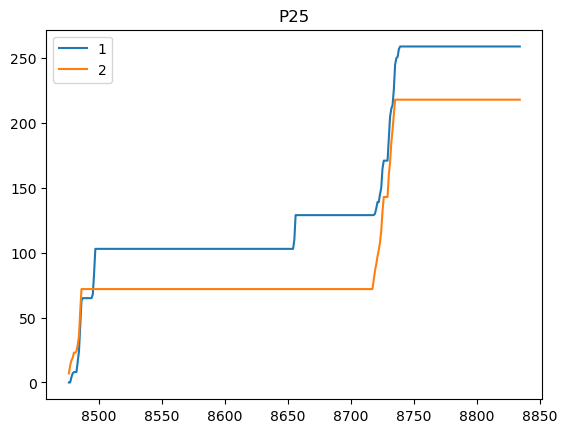

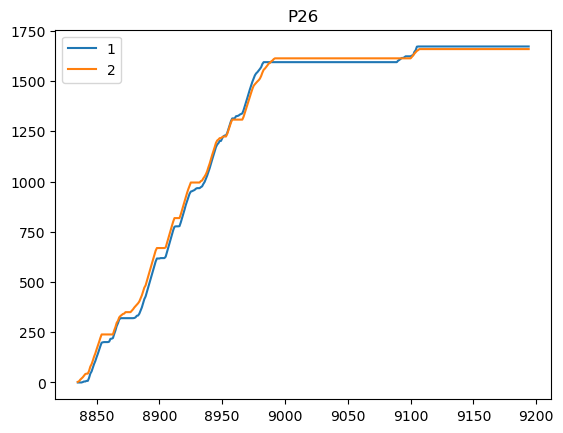

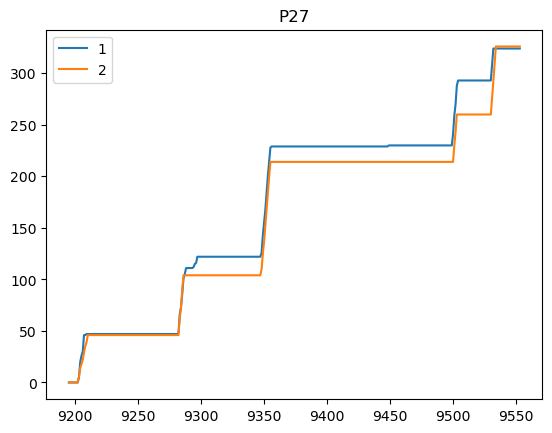

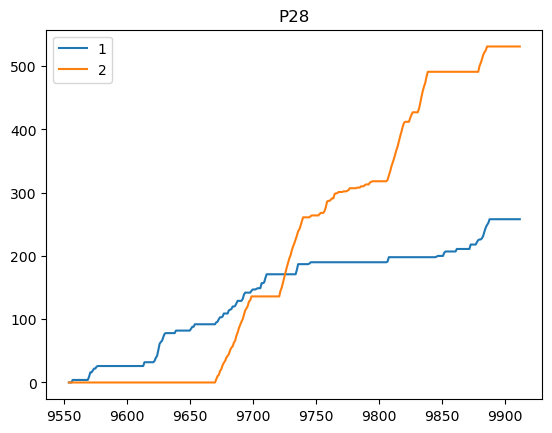

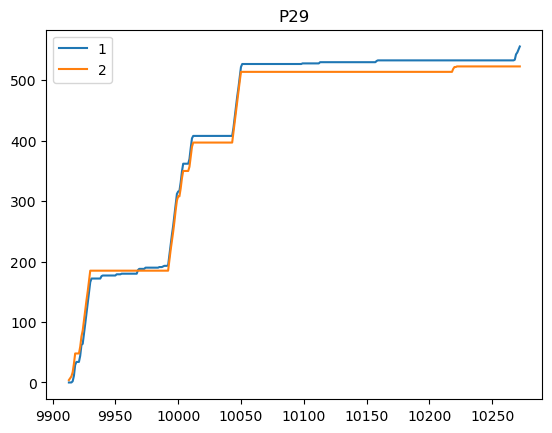

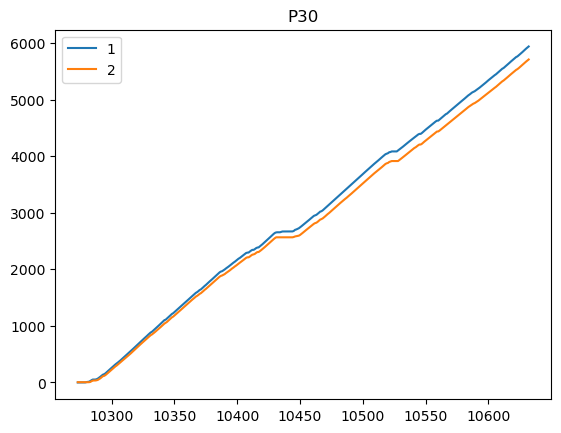

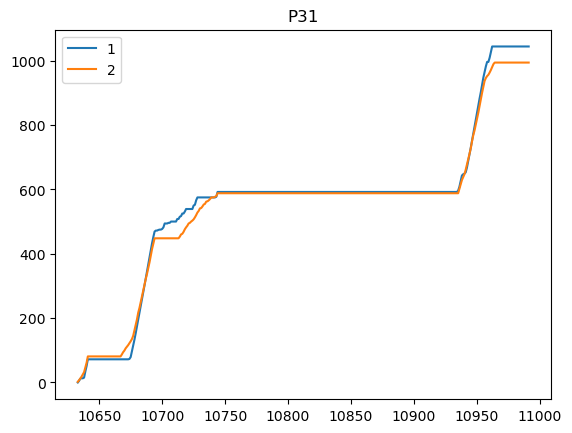

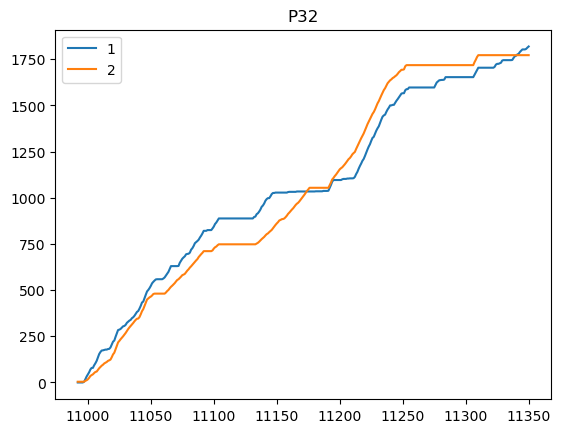

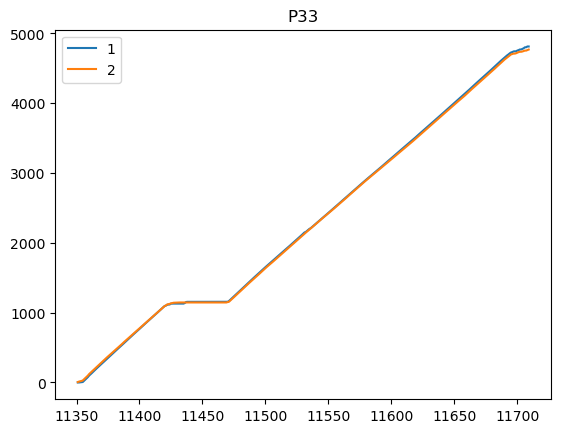

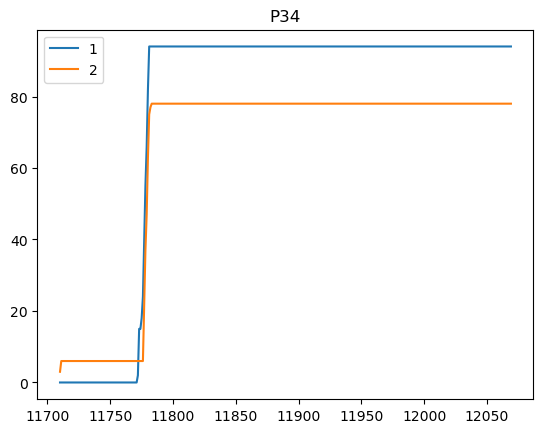

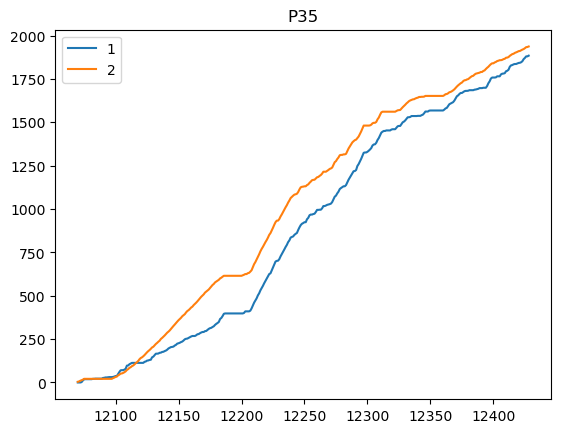

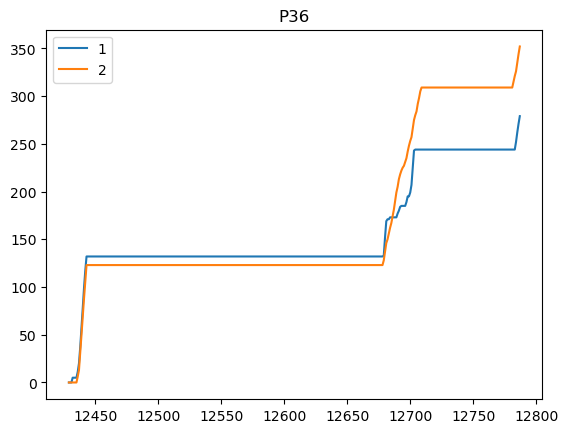

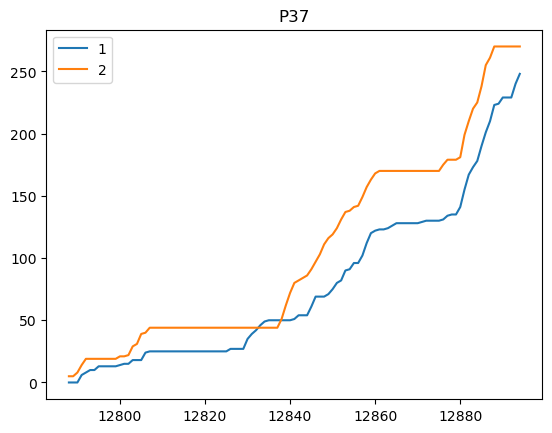

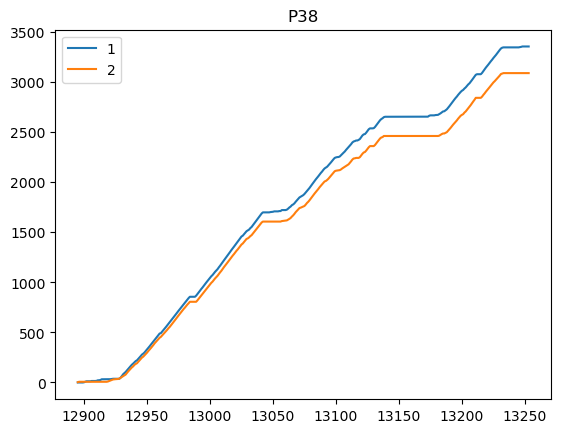

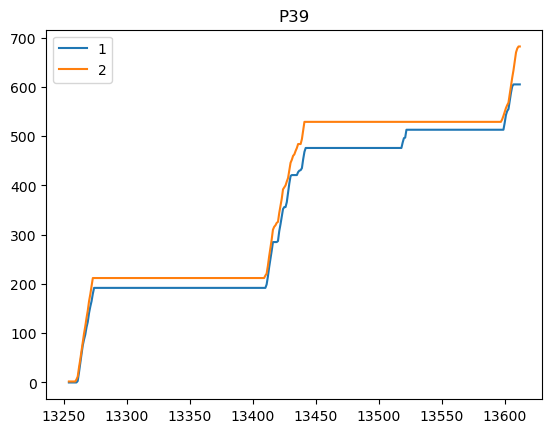

In [91]:
for g in np.unique(groups_test):
    preds[preds[0] == g][[1,2]].cumsum().plot.line()
    plt.title(g)
    plt.show()

In [92]:
pred_test = pd.concat([pd.Series(groups_test), pd.Series(T_test), pd.Series(Yp_test)], axis=1).rename(columns={0: "id_obs", 1: "time", 2: "pred_steps"})
pred_test

,id_obs,time,pred_steps
0,P01,2019-07-22 14:42:56.348,0
1,P01,2019-07-22 14:43:06.348,0
2,P01,2019-07-22 14:43:16.348,3
3,P01,2019-07-22 14:43:26.348,5
4,P01,2019-07-22 14:43:36.348,4
...,...,...,...
13608,P39,2019-07-22 14:31:52.819,18
13609,P39,2019-07-22 14:32:02.819,18
13610,P39,2019-07-22 14:32:12.819,8
13611,P39,2019-07-22 14:32:22.819,4


In [117]:
pred_test.to_csv("predicted_oxwalk_goldilocks.csv")

In [120]:
# pd.concat([pd.Series(groups_test), pd.Series(T_test), pd.Series(Y_step_test)], axis=1).to_csv("observed_oxwalk.csv")